# Importación de librerías

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import itertools
import matplotlib
from datetime import datetime 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
sns.set()

# 1. Forecast de ventas de vino

### 1.1 Exploración de datos

In [2]:
data = pd.read_csv('/home/ignacio/github/labIC/lab1/AustralianWines.csv')

In [3]:
data.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


In [4]:
data.dtypes

Month          object
Fortified       int64
Red             int64
Rose           object
sparkling       int64
Sweet white     int64
Dry white       int64
dtype: object

**Observamos que la columna Rose, no es de tipo entero**

In [5]:
data['Rose ']

0      112
1      118
2      129
3       99
4      116
      ... 
175      *
176     46
177     51
178     63
179     84
Name: Rose , Length: 180, dtype: object

**Se intentará encontrar las filas que contengan valores erróneos.**

In [6]:
notInt = {}
for i, value in enumerate(data['Rose ']):
    try:
        int(value)
    except:
        notInt[i] = value
print('Filas que no contienen valores enteros y su respectivo valor: ' , notInt)

Filas que no contienen valores enteros y su respectivo valor:  {174: '*', 175: '*'}


In [7]:
data[170:180]

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
170,Mar-94,1965,2201,42,1720,187,3754
171,Apr-94,2659,2455,48,1725,279,3708
172,May-94,2354,2204,44,1674,193,3210
173,Jun-94,2592,2660,45,1693,227,3517
174,Jul-94,2714,3670,*,2031,225,3905
175,Aug-94,2294,2665,*,1495,205,3670
176,Sep-94,2416,2639,46,2968,259,4221
177,Oct-94,2016,2226,51,3385,254,4404
178,Nov-94,2799,2586,63,3729,275,5086
179,Dec-94,2467,2684,84,5999,394,5725


**Por ahora solo reemplazaremos estos valores por cero (evaluar si se eliminan las filas, o reemplazamos por promedio)**

In [8]:
data['Rose '][174] = 0
data['Rose '][175] = 0
data['Rose '] = data['Rose '].astype(int)

<ipython-input-8-91e622e93bc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rose '][174] = 0
<ipython-input-8-91e622e93bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rose '][175] = 0


In [9]:
arr = [datetime(1980 + j, i + 1, 1)  for j in range(15) for i in range(12)]
data['Date'] = pd.DataFrame(arr, dtype = 'datetime64[ns]')

In [10]:
data = data.set_index('Date')

In [11]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01'],
              dtype='datetime64[ns]', name='Date', length=180, freq=None)

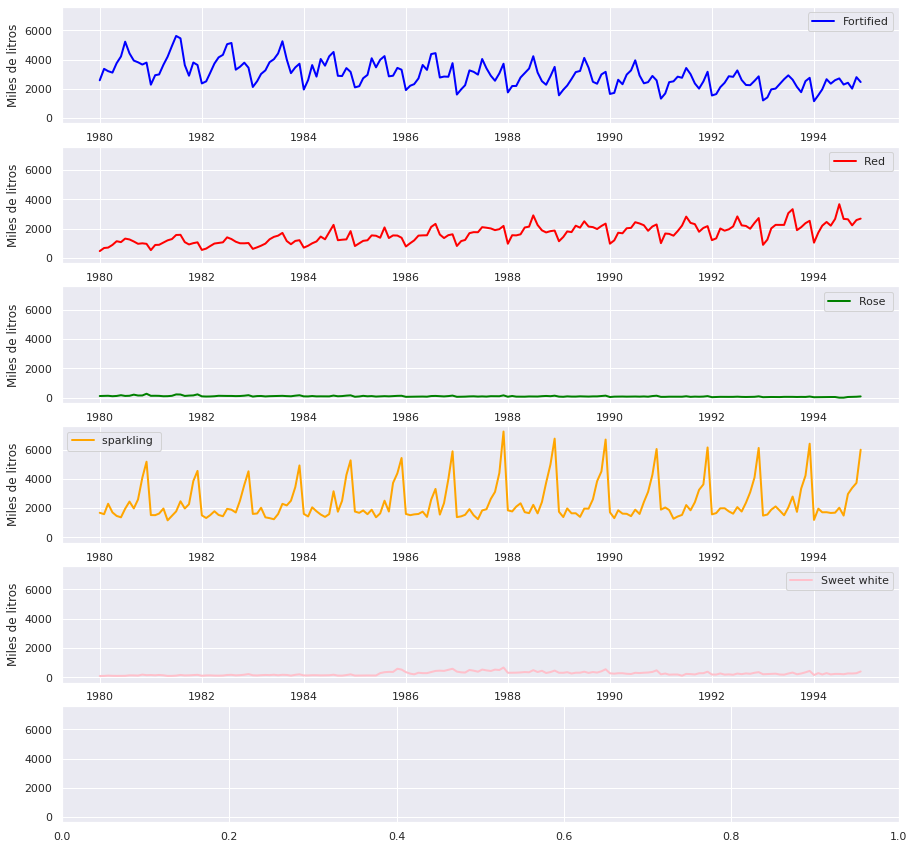

In [12]:
f, axes = plt.subplots(6, 1, sharey=True, figsize = (15,15))
colors = ['blue', 'red', 'green', 'orange', 'pink', 'purple']

for col, i, color in zip(data.columns[1:-1], range(6), colors):
    axes[i].plot(data[col], label = col, linewidth = 2, color = color)
    axes[i].legend()
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Miles de litros')


### 1.2 Seasonal descompose


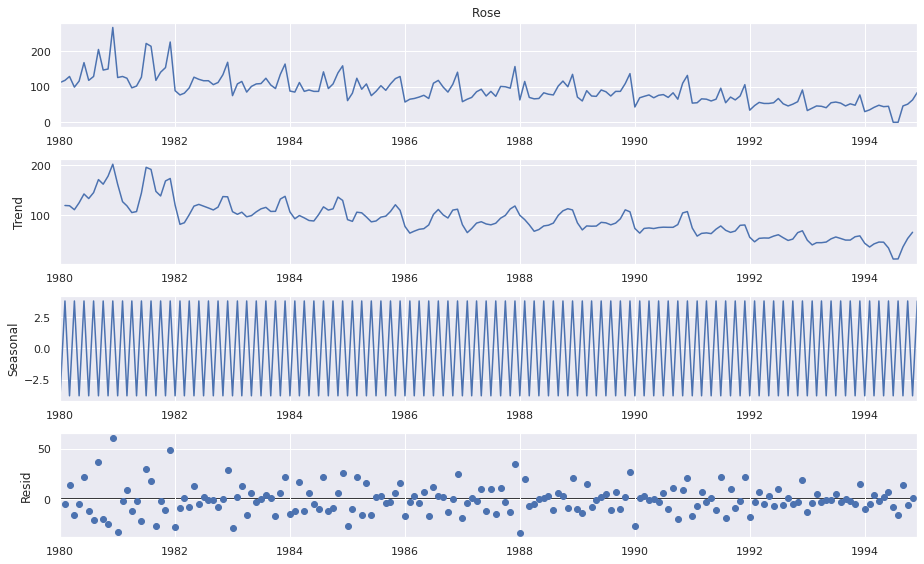

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
decomposition = sm.tsa.seasonal_decompose(data['Rose '], model='additive', period = 2)
fig = decomposition.plot()
plt.show()

### 1.3 Sarimax


In [225]:
train  = data[:126]
validacion = data[126:]

In [342]:
def sarimax_results(serie_name = 'Fortified'):
    predictions = []
    confidence = []
     
    dates = validacion.index
    mod = sm.tsa.statespace.SARIMAX(train[serie_name],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 0, 2),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    model_fit = mod.fit()
    
    for date1, date2 in zip(dates[0::2], dates[1::2]):
        yhat = model_fit.get_prediction(start= date1, end = date2)
        confidence.append(yhat.conf_int())
        predictions.extend(yhat.predicted_mean)
        
        model_fit = model_fit.extend(validacion[date1:date2][serie_name])
        
    return pd.DataFrame(predictions, index = dates,columns = ['Prediccion']), model_fit, confidence
 

In [356]:
def plot_results(pred, conf, serie_name): 
    ax = pred.plot()
    data[serie_name].plot(ax= ax, label = 'Real')

    upper= []
    lower = []
    idxs = []
    for value in conf:
        idx, y1, y2 = (value.index, value.iloc[:, 0], value.iloc[:, 1])
        upper.extend(y1)
        lower.extend(y2)
        idxs.extend(idx)

    ax.fill_between(x = idxs,
                    y1 = upper,
                    y2 = lower, color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Miles de litros')
    ax.set_title('Ventas de vino')
    plt.legend()
    plt.show()

In [368]:
def get_rmse(pred, serie_name):
    mse = ((np.asarray(pred)- np.asarray(validacion['Rose ']))**2).mean()
    rmse = round(np.sqrt(mse),2)
    return round(mse,2), rmse

In [370]:
mse, rmse = get_rmse(pred, serie_name)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


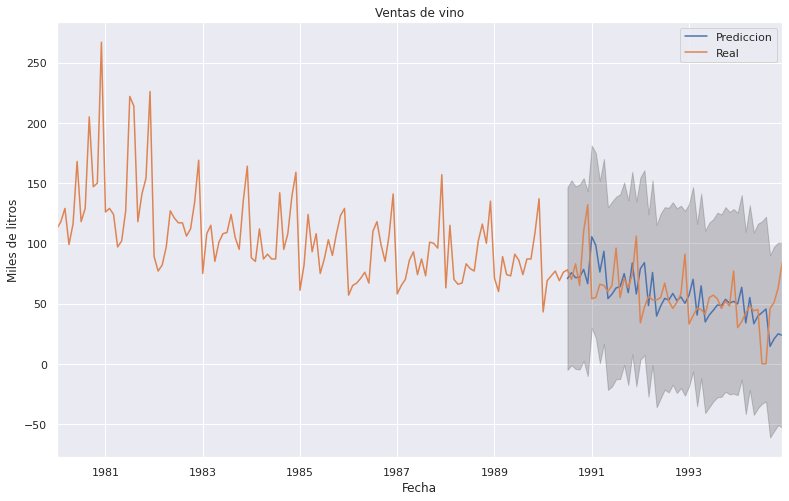

In [371]:
serie_name = 'Rose '
pred, model, conf = sarimax_results(serie_name)
plot_results(pred, conf, serie_name)

# 2. Diseño de Experimentos (DoE) para mejorar los costos de producción de una empresa de manufactura que utiliza fibra sintética

### 2.1 Datos 

### 2.2 ANOVA

### 2.3 [OPCIONAL] Prueba de comparaciones múltiples